In [12]:
#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6023581/

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import timeit
from numpy.fft import fft, fftfreq, ifft

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


In [3]:
tr_time = pd.read_csv("train_time_series.csv")
tr_lab = pd.read_csv("train_labels.csv")

In [4]:
tr_time = tr_time.drop(columns = ["accuracy", "UTC time", "timestamp"]).rename(columns = {"Unnamed: 0":"measurement"})
tr_lab = pd.read_csv("train_labels.csv").rename(columns = {"Unnamed: 0":"measurement"}).drop(columns = ["UTC time", "timestamp"])

In [5]:
tr_time

,measurement,x,y,z
0,20586,-0.006485,-0.934860,-0.069046
1,20587,-0.066467,-1.015442,0.089554
2,20588,-0.043488,-1.021255,0.178467
3,20589,-0.053802,-0.987701,0.068985
4,20590,-0.054031,-1.003616,0.126450
...,...,...,...,...
3739,24325,0.024384,-0.710709,0.030304
3740,24326,0.487228,-1.099136,-0.015213
3741,24327,0.369446,-0.968506,0.036713
3742,24328,0.167877,-0.802826,0.049805


In [6]:
tr_lab

,measurement,label
0,20589,1
1,20599,1
2,20609,1
3,20619,1
4,20629,1
...,...,...
370,24289,4
371,24299,4
372,24309,4
373,24319,4


In [7]:
def accel_mag(accels):
    """takes an array containing x,y,z accelerations, calculates their magnitude"""
    return np.sqrt(np.sum(accels**2))

def rotation(a):
    """for roll use a=y, b=z; for pitch use a=x, b=z; for yaw use a=y, b=x"""
    return np.arctan(a)

#sampling interval (s)
samp_int = 0.1
samp_freq = 1/samp_int
    


In [8]:
#if the above doesn't work aggregate the x's, the y's, the z's togehter - maybe use a sum or mean? then use x, y,z as input X for machine learning
start = timeit.default_timer()
previous = tr_time.measurement[0]

for i in tr_lab.measurement:
    boolinds = pd.Series((tr_time.measurement.values <= i + 5) & (tr_time.measurement.values > previous - 4))
    step = tr_time[boolinds.values]
    
    #calculate magnitude of acceleration and variation of acceleration for the step - maybe delete later    
    accels = step.loc[:,("x","y","z")]
    mags = accels.apply(accel_mag, axis="columns")

    
    #calculate rolls, pitch, yaws
    rolls = rotation([accels.y, accels.z])
    pitches = rotation([accels.x, accels.z])
    yaws = rotation([accels.y, accels.x])
    
    #mean mag
    tr_lab.loc[tr_lab.measurement == i, "mean_accel_mag"] = np.mean(mags)
    #SD mag
    tr_lab.loc[tr_lab.measurement == i, "SD_mag"] = np.std(mags)
    #mag var
    tr_lab.loc[tr_lab.measurement == i, "var_mag"] = np.var(mags)
    #Coeff of Variation / Relative SD
    tr_lab.loc[tr_lab.measurement == i, "RSD_mag"] = np.std(mags)/np.mean(mags)
    #mag min
    tr_lab.loc[tr_lab.measurement == i, "min_mag"] = np.amin(mags)
    #mag max
    tr_lab.loc[tr_lab.measurement == i, "max_mag"] = np.amax(mags)
    # mag 25, 50, 75 percentile
    tr_lab.loc[tr_lab.measurement == i, "per_25_mag"] = np.percentile(mags,25)
    tr_lab.loc[tr_lab.measurement == i, "per_50_mag"] = np.percentile(mags,50)
    tr_lab.loc[tr_lab.measurement == i, "per_75_mag"] = np.percentile(mags,75)
    #mean rotations
    tr_lab.loc[tr_lab.measurement == i, "mean_roll"] = np.mean(rolls)
    tr_lab.loc[tr_lab.measurement == i, "mean_pitch"] = np.mean(pitches)
    tr_lab.loc[tr_lab.measurement == i, "mean_yaw"] = np.mean(yaws)
    #SD rotations
    tr_lab.loc[tr_lab.measurement == i, "SD_roll"] = np.std(rolls)
    tr_lab.loc[tr_lab.measurement == i, "SD_pitch"] = np.std(pitches)
    tr_lab.loc[tr_lab.measurement == i, "SD_yaw"] = np.std(yaws)

    #Fourier transform each step
    


    previous = i
stop = timeit.default_timer()
print('Time: ', stop - start)  

Time:  7.902734099999996


In [9]:
step

,measurement,x,y,z
3730,24316,0.347946,-0.809662,0.075516
3731,24317,0.464157,-0.984344,0.009018
3732,24318,0.291733,-1.025040,-0.033188
3733,24319,0.330338,-1.470062,0.303894
3734,24320,0.285873,-1.063797,0.139603
3735,24321,0.652710,-1.040253,-0.106781
3736,24322,0.069305,-0.403793,0.054688
3737,24323,0.323227,-0.106842,0.032272
3738,24324,0.839401,-2.755875,0.775238
3739,24325,0.024384,-0.710709,0.030304


Text(0.5, 1.0, 'FFted')

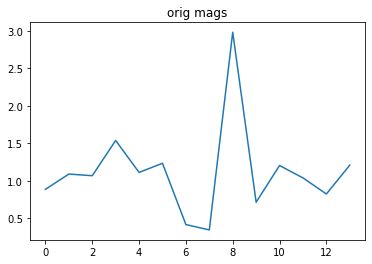

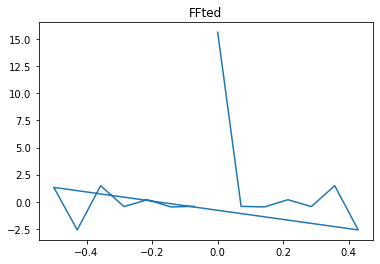

In [10]:
#num points
n = len(mags)

#create necessary frequencies
freqs = fftfreq(n)

#ignore neg freqs
mask = freqs > 0 

fft_vals = fft(mags)
fft_theo = 2*np.abs(fft_vals/n)

plt.figure(1)
plt.plot(np.arange(len(mags)), mags)
plt.title("orig mags")

plt.figure(2)
plt.plot(freqs, fft_vals)
#plt.plot(mask, fft_theo)
plt.title("FFted")



In [29]:
n

10

In [32]:
fft_theo

array([2.21250038, 0.21160516, 0.46188624, 0.5181233 , 0.60530629,
       0.39994938, 0.60530629, 0.5181233 , 0.46188624, 0.21160516])